#Satellite Imagery Feature Detection

**Problem Statement**:

Semantic segmentation in satellite imagery is a particularly relevant and important challenge due to (1) the availability of new data sources, (2) the growth of deep learning(since ~2015) which revolutionizes feature learning, and (3) environmental change, which ushers new demands for hazards monitoring, urban planning, and navigation (Vali et al., 2020). The availability of and interest in satellite imagery has grown since the start of the Landsat program in the 1970s, shifting more recently towards the study of hyperspectral data (consisting of images recorded in 13+ bands, i.e. portions of the electromagnetic spectrum) (Ibid.).

The main challenge with semantic segmentation is the high dimensionality of satellite imagery relative to the number of available ground truth labels. While the availability of satellite data has made land use mapping more cost-effective and less time-intensive, creating pixel-level labels is time-intensive. Approaches to addressing high dimensionality (spatial x spectral x time dimensions) and few labeled datasets include: (1) data augmentation, (2) dimensionality reduction (e.g.PCA), (3) GANs, (4) transfer learning, (5) unsupervised learning approaches. Additional challenges with semantic segmentation for satellite data include interband redundancy, nonlinear correlation between bands, and measurement noise and uncertainty about observed source (Vali et al., 2020).

Therefore, one of the key open questions related to the use of satellite image data is the tradeoff between spatial vs. spectral resolution: *for the purposes of object extraction from remote sensing, what representations of the earth are useful? High spectral resolution, or high spatial resolution?* In this project we explore this question through supervised and unsupervised approaches.

**Data Description**:

The satellite data we utilize is released by the Defence Science and Technology Laboratory (DSTL), originally released for use in a Kaggle competition ([link](https://www.kaggle.com/competitions/dstl-satellite-imagery-feature-detection/overview)).

The data consists of:

* 1km x 1km images taken by the WorldView-3 satellite, in both 3-band and 16-band, capturing wavelengths between 400nm - 2365nm. 
  * A detailed decsription of the WorldView-3 satellite can be found at [link](https://satimagingcorp.s3.amazonaws.com/site/pdf/WorldView3-DS-WV3-Web.pdf)
* Polygon labels of 10 classes (in well-known text (WKT) format:
  * Buildings
  * Misc. Manmade structures 
  * Road 
  * Track 
  * Trees 
  * Crops 
  * Waterway  
  * Standing water 
  * Vehicle Large 
  * Vehicle Small

**References**:

Abdollahi, A.; Pradhan, B.; Shukla, N.; Chakraborty, S.; Alamri, A. Deep Learning Approaches Applied to Remote Sensing Datasets for Road Extraction: A State-Of-The-Art Review. Remote Sens. 2020, 12, 1444. https://doi.org/10.3390/rs12091444

Talukdar, S.; Singha, P.; Mahato, S.; Shahfahad; Pal, S.; Liou, Y.-A.; Rahman, A. Land-Use Land-Cover Classification by Machine Learning Classifiers for Satellite Observations—A Review. Remote Sens. 2020, 12, 1135. https://doi.org/10.3390/rs12071135

Vali, A.; Comai, S.; Matteucci, M. Deep Learning for Land Use and Land Cover Classification Based on Hyperspectral and Multispectral Earth Observation Data: A Review. Remote Sens. 2020, 12, 2495. https://doi.org/10.3390/rs12152495

Kaggle: Dstl Satellite Imagery Feature Detection. Accessed May 8, 2022. https://www.kaggle.com/competitions/dstl-satellite-imagery-feature-detection/overview

## Data preprocessing:

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
FP = "/content/drive/MyDrive/AM216_SatelliteMaskingProjects/Final_project/data"

Mounted at /content/drive


In [2]:
from collections import defaultdict
import csv
import sys
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.patches as mpatches
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
csv.field_size_limit(sys.maxsize);

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ws4i1uvg
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ws4i1uvg


In [3]:
#  File with ground truth polygon locations (for all classes)
wkt_df = pd.read_csv(f"{FP}/train_wkt_v4.csv")
wkt_df.head()

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


In [4]:
# File with max x coordinate and min y coordinate for each image
# Used to scale the polygon coordinates (ground truth) to match the image pixels
grid_sizes_df = pd.read_csv(f"{FP}/grid_sizes.csv", names = ['ImageId', 'Xmax', 'Ymin'], skiprows=1)
grid_sizes_df.head()

,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


In [5]:
# References for pre-processing (heavily refactored):
# https://www.kaggle.com/code/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/notebook
# https://www.kaggle.com/code/drn01z3/end-to-end-baseline-with-u-net-keras/script

# ======= FUNCTIONS FOR PREPARATION OF GROUND TRUTH LABELS (USING THE WKT POLYGONS): =======
# Get max x coordinate and min y coordinate, using grid_sizes_df as lookup
def get_grid_size(grid_sizes_df, image_id):
  entry = grid_sizes_df.loc[grid_sizes_df['ImageId']==image_id]
  xmax = entry['Xmax'].item()
  ymin = entry['Ymin'].item()
  return xmax, ymin

# Get the scaling factors to use to scale the WKT polygon (ground truth mask) to match image pixels
def get_polygon_scaling_factors(grid_sizes_df, image_id, image_size):
  h, w = image_size
  xmax, ymin = get_grid_size(grid_sizes_df, image_id)
  x_scaling_factor = (w * (w / (w + 1))) / xmax
  y_scaling_factor = (h * (h / (h + 1))) / ymin
  return x_scaling_factor, y_scaling_factor

# Load scaled WKT polygon for the given image ID and class type, using wkt_df as lookup
def get_polygons(wkt_df, image_id, class_type, grid_sizes_df, image_size):
  entry = wkt_df.loc[(wkt_df['ImageId']==image_id)&(wkt_df['ClassType']==class_type)]
  scaled_polygons = None
  if len(entry) > 0:
    polygons = shapely.wkt.loads(entry['MultipolygonWKT'].item())
    x_scaling_factor, y_scaling_factor = get_polygon_scaling_factors(grid_sizes_df, image_id, image_size)
    scaled_polygons = shapely.affinity.scale(polygons, 
                                            xfact=x_scaling_factor, 
                                            yfact=y_scaling_factor, 
                                            origin=(0, 0, 0))
  return scaled_polygons

# Create a mask from scaled polygons
# Function from: https://www.kaggle.com/code/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/notebook
def mask_for_polygons(scaled_polygons, image_size):
  img_mask = np.zeros(image_size, np.uint8)
  if not scaled_polygons:
      return img_mask
  int_coords = lambda x: np.array(x).round().astype(np.int32)
  exteriors = [int_coords(poly.exterior.coords) for poly in scaled_polygons.geoms]
  interiors = [int_coords(pi.coords) for poly in scaled_polygons.geoms
               for pi in poly.interiors]
  cv2.fillPoly(img_mask, exteriors, 1)
  cv2.fillPoly(img_mask, interiors, 0)
  return img_mask

# ======= FUNCTIONS FOR PREPARATION OF IMAGES (THE FEATURES) =======
# Use percentiles to normalize img to the (0, 1) range
def normalize_pct(img, low_percentile = 1, high_percentile = 99):
  if len(img.shape) == 2:
    low = np.percentile(img, low_percentile)
    high = np.percentile(img, high_percentile)
    img = (img - low) / (high - low)
    img = img.clip(0,1)
  else: # normalize, channel-wise
    for c in range(img.shape[2]):
      low = np.percentile(img[:, :, c], low_percentile)
      high = np.percentile(img[:, :, c], high_percentile)
      img[:, :, c] = (img[:, :, c] - low) / (high - low)
      img[:, :, c] = img[:, :, c].clip(0,1)
  return img

## Plotting the 17 bands available for a single example image and class:

PANCHROMATIC BANDS:
Shape of single band:	(3348, 3403)
Shape of image mask:	(3348, 3403)

MULTISPECTRAL BANDS:
Shape of M tiff file:	(8, 837, 851)
Shape of single band:	(837, 851)

SWIR BANDS:
Shape of A tiff file: (8, 134, 137)
Shape of single band:	(134, 137)



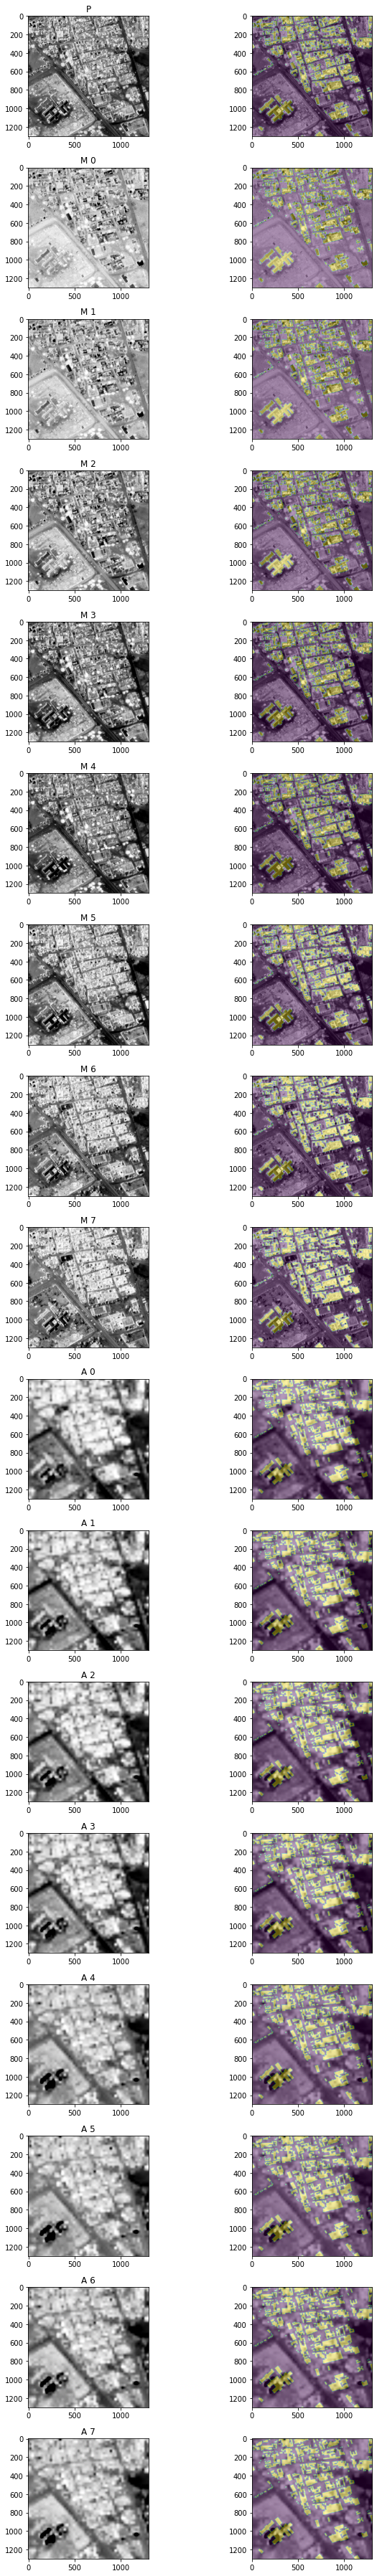

In [6]:
CLASS_LABELS = ['Buildings', 
                'Misc. Manmade Struct.', 
                'Road',
                'Track', 
                'Trees', 
                'Crops', 
                'Waterway', 
                'Standing Water', 
                'Vehicle Large', 
                'Vehicle Small']

IMAGE_ID = '6120_2_2'
CLASS_TYPE = 1

# See WorldView3 satellite specs at:
# https://satimagingcorp.s3.amazonaws.com/site/pdf/WorldView3-DS-WV3-Web.pdf

# P: Panchromatic bands (record 450-800nm wavelengths in one channel)
print("PANCHROMATIC BANDS:")
p_img = tiff.imread(f'{FP}/sixteen_band/{IMAGE_ID}_P.tif')
p_image_size = p_img.shape
print(f"Shape of single band:\t{p_image_size}")
p_scaled_polygons = get_polygons(wkt_df, IMAGE_ID, CLASS_TYPE, grid_sizes_df, p_image_size)
p_img_mask = mask_for_polygons(p_scaled_polygons, p_image_size)
print(f"Shape of image mask:\t{p_img_mask.shape}")
print()

# M: Multispectral bands (400 - 1040nm wavelengths)
print("MULTISPECTRAL BANDS:")
m_imgs = tiff.imread(f'{FP}/sixteen_band/{IMAGE_ID}_M.tif')
print(f"Shape of M tiff file:\t{m_imgs.shape}")
m_image_size = m_imgs[0].shape
print(f"Shape of single band:\t{m_image_size}")
m_imgs = [resize(m, p_image_size) for m in m_imgs]
print()

# A: SWIR bands (1195 - 2365nm wavelengths)
print("SWIR BANDS:")
a_imgs = tiff.imread(f'{FP}/sixteen_band/{IMAGE_ID}_A.tif')
print(f"Shape of A tiff file: {a_imgs.shape}")
a_image_size = a_imgs[0].shape
print(f"Shape of single band:\t{a_image_size}")
a_imgs = [resize(a, p_image_size) for a in a_imgs]
print()

fig, axes = plt.subplots(17, 2, figsize = (10,50))
normalized_p = normalize_pct(p_img)
axes[0][0].imshow(255 * normalized_p[2000:3300,2000:3300], cmap = "Greys")
axes[0][0].set_title(f"P")
axes[0][1].imshow(255 * normalized_p[2000:3300,2000:3300], cmap = "Greys")

for idx, m in enumerate(m_imgs):
  normalized_m = normalize_pct(m)
  axes[idx+1][0].imshow(255 * normalized_m[2000:3300,2000:3300], cmap = 'Greys')
  axes[idx+1][0].set_title(f"M {idx}")
  axes[idx+1][1].imshow(255 * normalized_m[2000:3300,2000:3300], cmap = 'Greys')

for idx, a in enumerate(a_imgs):
  normalized_a = normalize_pct(a)
  axes[idx+1+len(m_imgs)][0].imshow(255 * normalized_a[2000:3300,2000:3300], cmap = 'Greys')
  axes[idx+1+len(m_imgs)][0].set_title(f"A {idx}")
  axes[idx+1+len(m_imgs)][1].imshow(255 * normalized_a[2000:3300,2000:3300], cmap = 'Greys')

for i in range(17):
  axes[i][1].imshow(255 * p_img_mask[2000:3300,2000:3300], alpha = 0.4)

fig.tight_layout();

Notice that the dimensions of the images are different across bands (very high spatial resolution for panchromatic bands, and lower resolution for multispectral and SWIR bands). Therefore, to utilize all images with the same mask, we must either downsize the panchromatic image to the lowest resolution (SWIR band), or upsize the SWIR band to the highest resolution (Panchromatic band). The latter is preferable because then we do not lose granularity of the mask (ground truth labels).

## Supervised Modeling:

#### **Parameter definitions (supervised modeling base code part 1/3)**

In [8]:
# Learning parameters
# (these parameters are used when training each model, regardless of band type):
VALIDATION_PROP = 0.2     # fraction of data to use for train vs. test, and then also fraction of train to use as validation
EPOCHS = 10

# Get list of all Image IDs (note that these correspond to spatial regions) for which we have ground truth mask labels
IMAGE_ID_LIST = wkt_df.ImageId.unique().tolist()

#### **Preprocessing functions (supervised modeling base code part 2/3)**

In [89]:
## Define preprocessing functions...
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def load_images(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, normalize = True):
  images = []; masks = []
  for id in tqdm(IMAGE_ID_LIST):
    img = tiff.imread(f'{FP}/sixteen_band/{id}_{BAND_TYPE}.tif')
    img_size = img.shape[-2:]
    if len(img.shape) == 2:
      images.append(img[..., np.newaxis])
    else:
      images.append(np.rollaxis(img, 0, 3))
    scaled_polygons = get_polygons(wkt_df, id, CLASS_TYPE, grid_sizes_df, img_size)
    img_mask = mask_for_polygons(scaled_polygons, img_size)
    masks.append(img_mask[..., np.newaxis])
  min_x = min([i.shape[0] for i in images])
  min_y = min([i.shape[1] for i in images])
  images = [i[:min_x, :min_y, :].astype('float32') for i in images]
  masks = [m[:min_x, :min_y, :].astype('float32') for m in masks]
  if normalize: # normalize each image channel-wise
    images = [normalize_pct(i) for i in images]
  images = np.stack(images); masks = np.stack(masks)
  print(f"Shape of images:\t{images.shape}")
  print(f"Shape of masks:\t\t{masks.shape}")
  return images, masks

# Augmentation class for segmentation: 
# https://www.tensorflow.org/tutorials/images/segmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed = 42, rotation_factor = 0.5):
    super().__init__()
    self.flip_inputs = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed = seed)
    self.rotate_inputs = tf.keras.layers.RandomRotation(rotation_factor, seed = seed)
    self.flip_labels = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed = seed)
    self.rotate_labels = tf.keras.layers.RandomRotation(rotation_factor, seed = seed)

  def call(self, inputs, labels):
    inputs = self.rotate_inputs(self.flip_inputs(inputs))
    labels = self.rotate_labels(self.flip_labels(labels))
    return inputs, labels

def process_data(fp, image_id_list, band_type, class_type, wkt_df, grid_sizes_df, validation_prop = 0.2):
  print("Loading images...")
  images, masks = load_images(fp, image_id_list, band_type, class_type, wkt_df, grid_sizes_df)

  # Training dataset
  imgs_train, imgs_test, imgs_mask_train, imgs_mask_test = train_test_split(images, masks, 
                                                                          test_size = validation_prop, 
                                                                          random_state = 42)
  imgs_train, imgs_val, imgs_mask_train, imgs_mask_val = train_test_split(imgs_train, imgs_mask_train, 
                                                                          test_size = validation_prop, 
                                                                          random_state = 42)
  train_data = tf.data.Dataset.from_tensor_slices((imgs_train, imgs_mask_train))

  # Validation dataset
  val_data = tf.data.Dataset.from_tensor_slices((imgs_val, imgs_mask_val))

  # Test dataset
  test_data = tf.data.Dataset.from_tensor_slices((imgs_test, imgs_mask_test))

  return train_data, val_data, test_data

# aug_increase is the # of times to increase the data via augmentation
def get_patched_data(train_data, val_data, test_data, n_input_channels = 8, buffer_size = 1000, aug_increase = 8):
  # Creating patches from images:
  # Modified from: https://stackoverflow.com/questions/64326029/load-tensorflow-images-and-create-patches
  get_patches = lambda x, y: (tf.reshape(tf.image.extract_patches(
        images=tf.expand_dims(x, 0),
        sizes=[1, 128, 128, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'), 
        (-1, 128, 128, n_input_channels)),
    tf.reshape(tf.image.extract_patches(
        images=tf.expand_dims(y, 0),
        sizes=[1, 128, 128, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'),
        (-1, 128, 128, 1)))
  train_data_patched = (
    train_data
    .map(get_patches)
    .shuffle(buffer_size)
    .cache()
    .repeat(aug_increase) # repeat before augment?
    .map(Augment(), num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
  )
  val_data_patched = (
      val_data
      .map(get_patches)
  )
  test_data_patched = (
      test_data
      .map(get_patches)
  )
  return train_data_patched, val_data_patched, test_data_patched

#### **Modeling functions (supervised modeling base code part 3/3)**

In [10]:
# Dice loss with cross entropy:
# https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
def dice_bc_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)

      return 1 - numerator / denominator

    #y_true = tf.cast(y_true, tf.float32)
    o = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

# Define the model type:
def build_model(n_input_channels = 8):
  # unet with pretrained mobilenetv2 encoder 
  # ATTRIBUTION: https://www.tensorflow.org/tutorials/images/segmentation#define_the_model
  # modified to accept arbitrary n_channels via addition of a 2D conv layer
  # define encoder:
  base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)
  layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  down_stack.trainable = False

  # define decoder:
  up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]

  def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=(128, 128, n_input_channels))

     # convert 8 channel to 3 channel:
    dense_filter = tf.keras.layers.Conv2D(3, n_input_channels, padding='same')(inputs) #####

    # downsample
    # skips = down_stack(inputs)
    skips = down_stack(dense_filter) ####
    x = skips[-1]
    skips = reversed(skips[:-1])

    # upsample w/ skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = tf.keras.activations.sigmoid(last(x)) # apply sigmoid
    return tf.keras.Model(inputs=inputs, outputs=x)

  model = unet_model(output_channels=1)
  return model

def model_train(model,train_data, val_data, loss_function = 'dice_bc', learning_rate = 0.001):
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
                loss = dice_bc_loss if loss_function == 'dice_bc' else 'binary_crossentropy',
                metrics = ['accuracy'])

  print('*'*30)
  print('Fitting model...')
  print('*'*30)
  history =  model.fit(train_data, 
                      epochs = EPOCHS,
                      validation_data = val_data,
                      verbose=1)
  return history

# Visualize model predictions
# num_images: how many images to show
# _band_for_viz: which band to show (for overlay)
def viz_predictions(test_imgs, test_masks, test_pred, class_type, band_type, num_images = 5, _band_for_viz = 7):
  truth_color = matplotlib.colors.ListedColormap(['none', 'blue'])
  pred_color = matplotlib.colors.ListedColormap(['none', 'red'])
  fig, axes = plt.subplots(2, num_images, figsize = (13,5))
  fig.subplots_adjust(top=0.85)

  for i in range(num_images):
    axes[0][i].imshow(test_imgs[i][:,:,_band_for_viz].squeeze(), cmap = 'Greys')
    axes[0][i].xaxis.set_ticks([]); axes[0][i].yaxis.set_ticks([])
    axes[1][i].imshow(test_masks[i].squeeze(), cmap = truth_color, alpha = 0.5)
    axes[1][i].imshow(test_pred[i].squeeze(), cmap = pred_color, alpha = 0.5)
    axes[1][i].xaxis.set_ticks([]); axes[1][i].yaxis.set_ticks([])

  # Adding legend to imshow:
  # https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
  patches = [mpatches.Patch(color=['blue', 'red'][i], 
                            label=f"{[f'true {CLASS_LABELS[class_type-1]}', f'predicted {CLASS_LABELS[class_type-1]}'][i]}")for i in range(2) ]
  fig.legend(handles=patches, loc = (0.7, 0.88), ncol = 2);
  fig.suptitle(f"{num_images} Test Set Predictions ({band_type} model)", y = 0.98);

def get_pixel_jaccard(pred, truth):
  # Get pixel-level Jaccard
  # based on https://www.kaggle.com/code/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/notebook
  tp, fp, fn = (( (pred==1) &  (truth==1)).sum(),
                ( (pred==1) & ~(truth==1)).sum(),
                (~(pred==1) &  (truth==1)).sum())
  jc = tp / (tp + fp + fn)
  print('Pixel jaccard:', jc)
  return jc

#### **MULTISPECTRAL MODEL**

In [73]:
BAND_TYPE = 'M'
CLASS_TYPE = 5
N_INPUT_CHANNELS = 8

# Load images
train_data, val_data, test_data = process_data(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, VALIDATION_PROP)
print(f"Number of images in train data: {len(train_data)}")
print(f"Number of images in val data: {len(val_data)}")
print(f"Number of images in test data: {len(test_data)}")

# Convert images to patches
train_patched, val_patched, test_patched = get_patched_data(train_data, val_data, test_data, 
                                                            n_input_channels = N_INPUT_CHANNELS, 
                                                            buffer_size = 36 * len(train_data), 
                                                            aug_increase = 5)
print(f"Shape of single example after patching: {next(iter(train_patched))[0].shape}")

Loading images...


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Shape of images:	(25, 837, 835, 8)
Shape of masks:		(25, 837, 835, 1)
Number of images in train data: 16
Number of images in val data: 4
Number of images in test data: 5
Shape of single example after patching: (36, 128, 128, 8)


Shape of patched image: (36, 128, 128, 8)


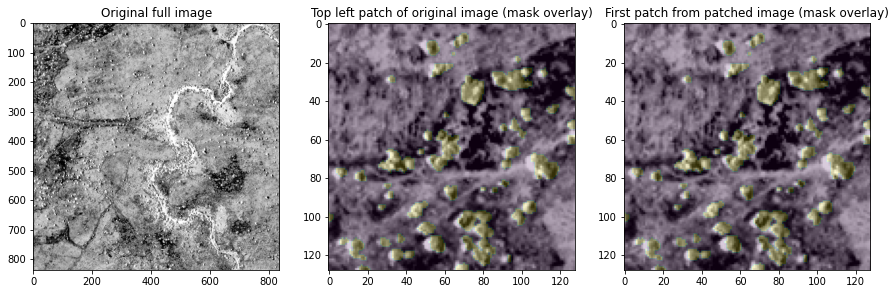

In [74]:
### (This cell is for sense-checking only, to verify that patching indeed works as expected):

# Patching function
get_patches = lambda x, y: (tf.reshape(tf.image.extract_patches(
      images=tf.expand_dims(x, 0),
      sizes=[1, 128, 128, 1],
      strides=[1, 128, 128, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'), 
      (-1, 128, 128, 8)),
  tf.reshape(tf.image.extract_patches(
      images=tf.expand_dims(y, 0),
      sizes=[1, 128, 128, 1],
      strides=[1, 128, 128, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'),
      (-1, 128, 128, 1)))

# Comparing patches vs. crops to verify that patching indeed works as expected:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
_band_for_viz = 7
_fullimg, _fullmask = next(iter(train_data))
axes[0].imshow(_fullimg[:, :, _band_for_viz], cmap = 'Greys')
axes[0].set_title("Original full image")

axes[1].imshow(_fullimg[:128, :128, _band_for_viz], cmap = 'Greys')
axes[1].imshow(_fullmask[:128, :128, 0], alpha = 0.2)
axes[1].set_title("Top left patch of original image (mask overlay)")

_patchimg, _patchmask = next(iter(train_data.map(get_patches)))
print(f"Shape of patched image: {_patchimg.shape}")
axes[2].imshow(_patchimg[0][:, :, _band_for_viz], cmap = 'Greys')
axes[2].imshow(_patchmask[0][:, :, 0], alpha = 0.2)
axes[2].set_title("First patch from patched image (mask overlay)");

Shape of single example after patching: (36, 128, 128, 8)


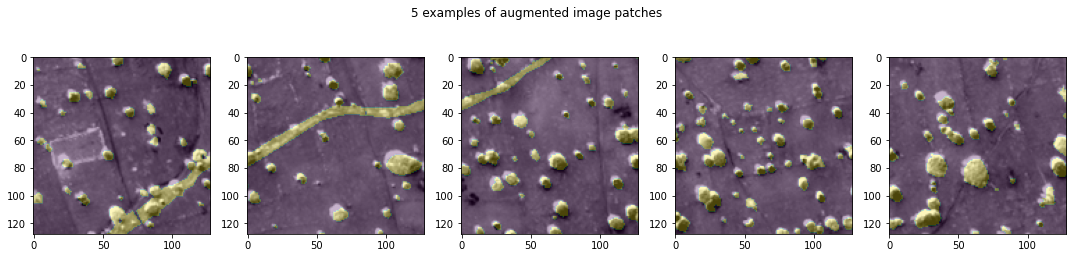

In [75]:
### (This cell is for sense-checking only, to verify that patching + augmentation indeed works as expected):
n_patches_to_show = 5
fig, axes = plt.subplots(1, n_patches_to_show, figsize = (15,4))
_patchimg, _patchmask = next(iter(train_patched))
print(f"Shape of single example after patching: {_patchimg.shape}")

for p in range(n_patches_to_show):
  axes[p].imshow(_patchimg[p][:, :, _band_for_viz], cmap = 'Greys')
  axes[p].imshow(_patchmask[p][:, :, 0], alpha = 0.3)
fig.suptitle(f"{n_patches_to_show} examples of augmented image patches")
fig.tight_layout();

In [76]:
model = build_model(n_input_channels = N_INPUT_CHANNELS)
model_history = model_train(model, train_patched, val_patched, learning_rate = 0.003)

******************************
Fitting model...
******************************
Epoch 1/10
80/80 [==============================] - 11s 91ms/step - loss: 0.8650 - accuracy: 0.8761 - val_loss: 3.1775 - val_accuracy: 0.4383
Epoch 2/10
80/80 [==============================] - 6s 80ms/step - loss: 0.6895 - accuracy: 0.9042 - val_loss: 1.2115 - val_accuracy: 0.7846
Epoch 3/10
80/80 [==============================] - 6s 80ms/step - loss: 0.6507 - accuracy: 0.9095 - val_loss: 0.6443 - val_accuracy: 0.9272
Epoch 4/10
80/80 [==============================] - 6s 79ms/step - loss: 0.6055 - accuracy: 0.9172 - val_loss: 0.6491 - val_accuracy: 0.9331
Epoch 5/10
80/80 [==============================] - 6s 79ms/step - loss: 0.5916 - accuracy: 0.9192 - val_loss: 0.6557 - val_accuracy: 0.9334
Epoch 6/10
80/80 [==============================] - 6s 79ms/step - loss: 0.5681 - accuracy: 0.9230 - val_loss: 0.7454 - val_accuracy: 0.9305
Epoch 7/10
80/80 [==============================] - 6s 79ms/step - loss: 0

In [77]:
test_pred = model.predict(test_patched)
# convert predictions to binary values based on probability > threshold
pred_threshold = 0.2
test_pred = test_pred >= pred_threshold
test_masks = np.concatenate([y for x, y in test_patched], axis=0)
test_imgs = np.concatenate([x for x, y in test_patched], axis=0)
print(test_masks.shape)
print(test_imgs.shape)

(180, 128, 128, 1)
(180, 128, 128, 8)


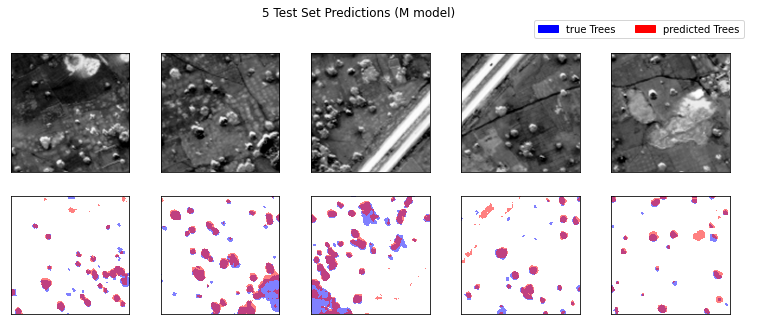

In [78]:
viz_predictions(test_imgs, test_masks, test_pred, class_type = CLASS_TYPE, band_type = BAND_TYPE, num_images = 5, _band_for_viz = 7);

In [81]:
jc = get_pixel_jaccard(test_pred, test_masks)

Pixel jaccard: 0.471439610923631


In [82]:
print(len(train_data))
print(len(train_patched)) # this is (# times augment) x (len(train_data))

16
80


#### **SWIR MODEL**

In [83]:
BAND_TYPE = 'A'
CLASS_TYPE = 5
N_INPUT_CHANNELS = 8

# Load images
train_data, val_data, test_data = process_data(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, VALIDATION_PROP)
print(f"Number of images in train data: {len(train_data)}")
print(f"Number of images in val data: {len(val_data)}")
print(f"Number of images in test data: {len(test_data)}")

# Convert images to patches
train_patched, val_patched, test_patched = get_patched_data(train_data, val_data, test_data, 
                                                            n_input_channels = N_INPUT_CHANNELS, 
                                                            buffer_size = 36 * len(train_data), 
                                                            aug_increase = 10)

print(f"Shape of single example after patching: {next(iter(train_patched))[0].shape}")

Loading images...


100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


Shape of images:	(25, 133, 134, 8)
Shape of masks:		(25, 133, 134, 1)
Number of images in train data: 16
Number of images in val data: 4
Number of images in test data: 5
Shape of single example after patching: (1, 128, 128, 8)


In [84]:
model = build_model(n_input_channels = N_INPUT_CHANNELS)
model_history = model_train(model, train_patched, val_patched, learning_rate = 0.001)

******************************
Fitting model...
******************************
Epoch 1/10
160/160 [==============================] - 6s 20ms/step - loss: 1.2249 - accuracy: 0.6446 - val_loss: 1.1952 - val_accuracy: 0.6692
Epoch 2/10
160/160 [==============================] - 2s 15ms/step - loss: 1.0224 - accuracy: 0.7374 - val_loss: 1.1559 - val_accuracy: 0.6931
Epoch 3/10
160/160 [==============================] - 2s 15ms/step - loss: 0.8457 - accuracy: 0.7985 - val_loss: 1.1531 - val_accuracy: 0.7133
Epoch 4/10
160/160 [==============================] - 2s 15ms/step - loss: 0.6558 - accuracy: 0.8527 - val_loss: 1.1729 - val_accuracy: 0.7070
Epoch 5/10
160/160 [==============================] - 2s 15ms/step - loss: 0.5012 - accuracy: 0.8918 - val_loss: 1.2080 - val_accuracy: 0.7025
Epoch 6/10
160/160 [==============================] - 2s 15ms/step - loss: 0.3844 - accuracy: 0.9197 - val_loss: 1.2304 - val_accuracy: 0.7237
Epoch 7/10
160/160 [==============================] - 2s 15ms/s

(5, 128, 128, 1)
(5, 128, 128, 8)


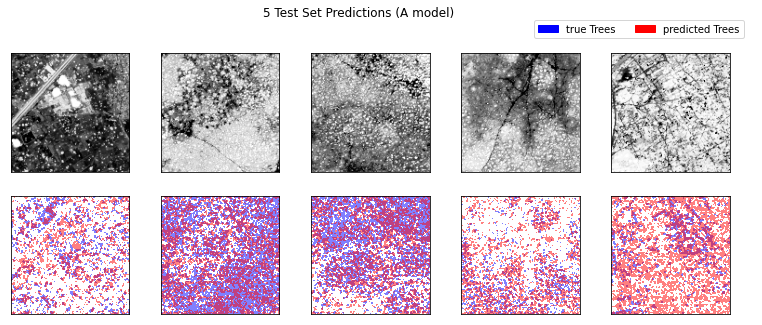

In [85]:
test_pred = model.predict(test_patched)
# convert predictions to binary values based on probability > threshold
pred_threshold = 0.2
test_pred = test_pred >= pred_threshold
test_masks = np.concatenate([y for x, y in test_patched], axis=0)
test_imgs = np.concatenate([x for x, y in test_patched], axis=0)
print(test_masks.shape)
print(test_imgs.shape)

viz_predictions(test_imgs, test_masks, test_pred, class_type = CLASS_TYPE, band_type = BAND_TYPE, num_images = 5, _band_for_viz = 7);

In [86]:
jc = get_pixel_jaccard(test_pred, test_masks)

Pixel jaccard: 0.3336254151977666


In [87]:
print(len(train_data))
print(len(train_patched)) # this is (# times augment) x (len(train_data))

16
160


#### **PANCHROMATIC MODEL**

In [113]:
BAND_TYPE = 'P'
CLASS_TYPE = 5
N_INPUT_CHANNELS = 1

# Load images
train_data, val_data, test_data = process_data(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, VALIDATION_PROP)
print(f"Number of images in train data: {len(train_data)}")
print(f"Number of images in val data: {len(val_data)}")
print(f"Number of images in test data: {len(test_data)}")

# Convert images to patches
train_patched, val_patched, test_patched = get_patched_data(train_data, val_data, test_data, 
                                                            n_input_channels = N_INPUT_CHANNELS, 
                                                            buffer_size = 36 * len(train_data), 
                                                            aug_increase = 1)

print(f"Shape of single example after patching: {next(iter(train_patched))[0].shape}")

Loading images...


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Shape of images:	(25, 3348, 3338, 1)
Shape of masks:		(25, 3348, 3338, 1)
Number of images in train data: 16
Number of images in val data: 4
Number of images in test data: 5
Shape of single example after patching: (676, 128, 128, 1)


Shape of single example after patching: (676, 128, 128, 1)


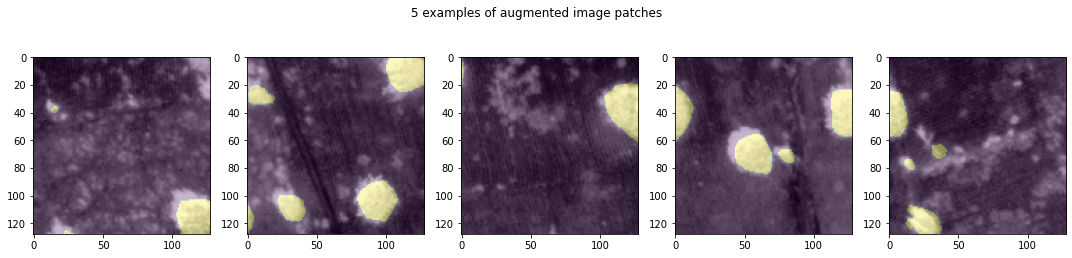

In [129]:
### (This cell is for sense-checking only, to verify that patching + augmentation indeed works as expected):
n_patches_to_show = 5
fig, axes = plt.subplots(1, n_patches_to_show, figsize = (15,4))
_patchimg, _patchmask = next(iter(train_patched))
print(f"Shape of single example after patching: {_patchimg.shape}")

for p in range(n_patches_to_show):
  axes[p].imshow(_patchimg[p][:, :, 0], cmap = 'Greys')
  axes[p].imshow(_patchmask[p][:, :, 0], alpha = 0.3)
fig.suptitle(f"{n_patches_to_show} examples of augmented image patches")
fig.tight_layout();

In [130]:
model = build_model(n_input_channels = N_INPUT_CHANNELS)

# since the images are too large, we have to unbatch each set of patches, and rebatch into 64 (i.e. accept 64 patches at a time)
model_history = model_train(model, 
                            train_patched.unbatch().batch(64), 
                            val_patched.unbatch().batch(64), 
                            learning_rate = 0.001)

******************************
Fitting model...
******************************
Epoch 1/10
169/169 [==============================] - 27s 133ms/step - loss: 0.9687 - accuracy: 0.8856 - val_loss: 0.7429 - val_accuracy: 0.9198
Epoch 2/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8306 - accuracy: 0.9001 - val_loss: 0.7277 - val_accuracy: 0.9364
Epoch 3/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8217 - accuracy: 0.9002 - val_loss: 0.7100 - val_accuracy: 0.9354
Epoch 4/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8164 - accuracy: 0.9008 - val_loss: 0.7272 - val_accuracy: 0.9370
Epoch 5/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8091 - accuracy: 0.9018 - val_loss: 0.7114 - val_accuracy: 0.9362
Epoch 6/10
169/169 [==============================] - 21s 126ms/step - loss: 0.8007 - accuracy: 0.9030 - val_loss: 0.7034 - val_accuracy: 0.9346
Epoch 7/10
169/169 [==============================]

(3380, 128, 128, 1)
(3380, 128, 128, 1)


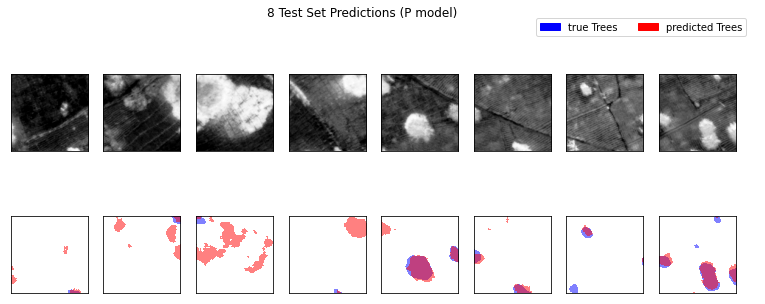

In [135]:
test_pred = model.predict(test_patched)
# convert predictions to binary values based on probability > threshold
pred_threshold = 0.2
test_pred = test_pred >= pred_threshold
test_masks = np.concatenate([y for x, y in test_patched], axis=0)
test_imgs = np.concatenate([x for x, y in test_patched], axis=0)
print(test_masks.shape)
print(test_imgs.shape)

viz_predictions(test_imgs, test_masks, test_pred, class_type = CLASS_TYPE, band_type = BAND_TYPE, num_images = 8, _band_for_viz = 0);

In [136]:
jc = get_pixel_jaccard(test_pred, test_masks)

Pixel jaccard: 0.42714259590271914


## Unsupervised exploration:

In [ ]:
# Unsupervised exploration

# image_class_vectors = []
# for i in image ids:
#   for c in classes:
#     scaled_polygons = get_polygons(wkt_df, i, c, grid_sizes_df, RESIZED_SHAPE)
#     IMG_MASK = mask_for_polygons(scaled_polygons, RESIZED_SHAPE)
#     for bands corerseponding to id i (17 image types):
#       image_class_vectors.append(i[IMG_MASK == 1, class = c]) # optionally avg per image
#       image.resize(largest img shape) from sklearn.image; or image.resize(837, 851)
# image matrix = np.vstack(image_class_vector)
# pca  on image-class-vecors --> 2D; (n images x 2 matrix) or umap
# viz w/ plot, color by class
# (k-means)

# Supervised:
# Train panchromatic only model (e.g. unet)
# Train multispectral only model (e.g. unet)
# Train SWIR only model (e.g. unet)

# (for these, only need to prepare mask once, then take patches and augment each 
# (also augment the corresponding mask patch))
# order: patch --> resize --> augment (rotate, flip)